In [ ]:
import zipfile
with zipfile.ZipFile('/content/FruitinAmazon.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')

In [ ]:
train_dir = '/content/drive/MyDrive/FruitinAmazon/train'
test_dir = '/content/drive/MyDrive/FruitinAmazon/test'

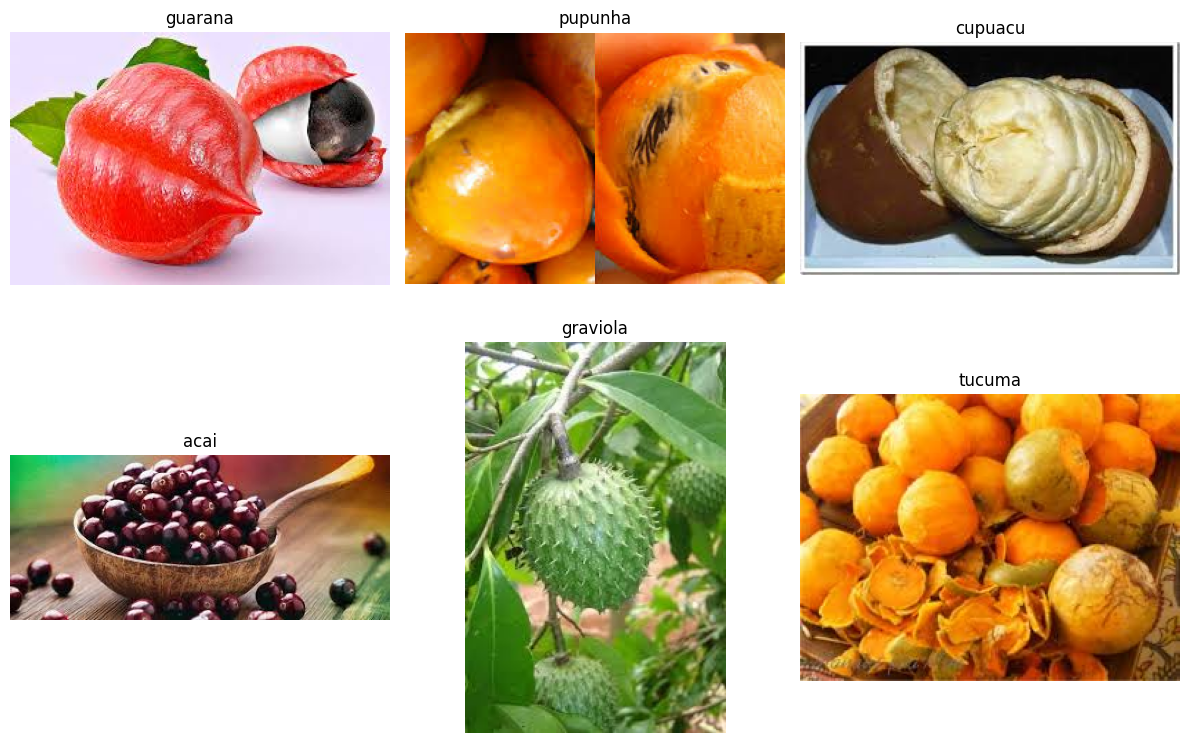

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


# Get the list of class directories
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Shuffle class list for display variety
random.shuffle(classes)

# Select one random image from each class
sample_images = []
sample_labels = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        img_file = random.choice(image_files)
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert('RGB')
        sample_images.append(img)
        sample_labels.append(class_name)

# Plotting - display in grid with 2 rows
num_images = len(sample_images)
num_cols = (num_images + 1) // 2

plt.figure(figsize=(4 * num_cols, 8))  # Adjust figure size if needed

for i, img in enumerate(sample_images):
    plt.subplot(2, num_cols, i + 1)
    plt.imshow(img)
    plt.title(sample_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image, UnidentifiedImageError

# List to store corrupted image paths
corrupted_images = []

# Loop through each class subdirectory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            with Image.open(img_path) as img:
                img.verify()  # Verify that it's a valid image
        except (IOError, SyntaxError, UnidentifiedImageError):
            corrupted_images.append(img_path)
            os.remove(img_path)
            print(f"Removed corrupted image: {img_path}")

# Final output
if not corrupted_images:
    print("No corrupted images found.")


No corrupted images found.


In [ ]:
class_counts = {}
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
guarana                               15
pupunha                               15
cupuacu                               15
acai                                  15
graviola                              15
tucuma                                15


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
import os

# Define constants
img_height = 224
img_width = 224
batch_size = 16
validation_split = 0.2
seed = 123

# Normalization layer
rescale = tf.keras.layers.Rescaling(1./255)

raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=seed
)

# Extract class names before mapping
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# Normalize dataset
train_ds = raw_train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=seed
)
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D((2, 2), strides=2),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  # tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  # tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  # tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Setup directory to save best model
checkpoint_path = "best_model.h5"
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    )
]
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)



Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2775 - loss: 2.0744 - val_accuracy: 0.0000e+00 - val_loss: 3.9460
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3336 - loss: 1.5578 - val_accuracy: 0.0000e+00 - val_loss: 2.9494
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5735 - loss: 1.2359 - val_accuracy: 0.0000e+00 - val_loss: 2.2330
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7054 - loss: 0.8884 - val_accuracy: 0.0556 - val_loss: 1.9875
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7182 - loss: 0.8085 - val_accuracy: 0.2778 - val_loss: 1.6720
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8041 - loss: 0.6910 - val_accuracy: 0.5556 - val_loss: 1.6118
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8223 - loss: 0.5385 - val_accuracy: 0.5000 - val_loss: 1.6668
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8501 - loss: 0.4925 - val_accuracy: 0.5000 - val

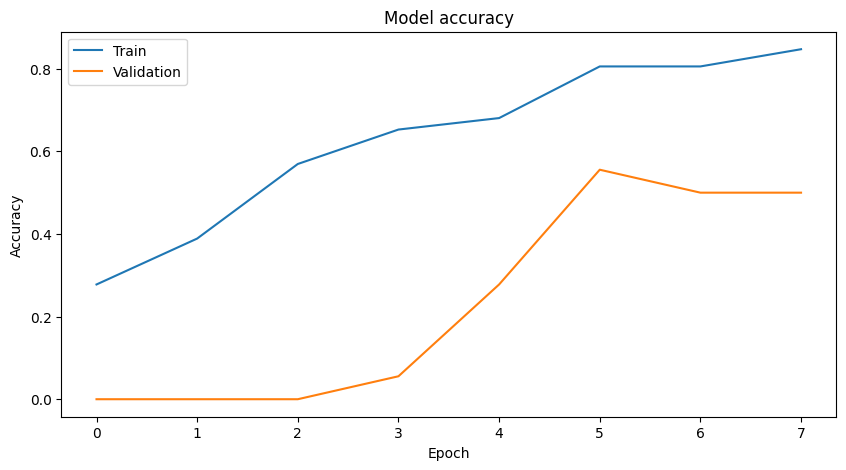

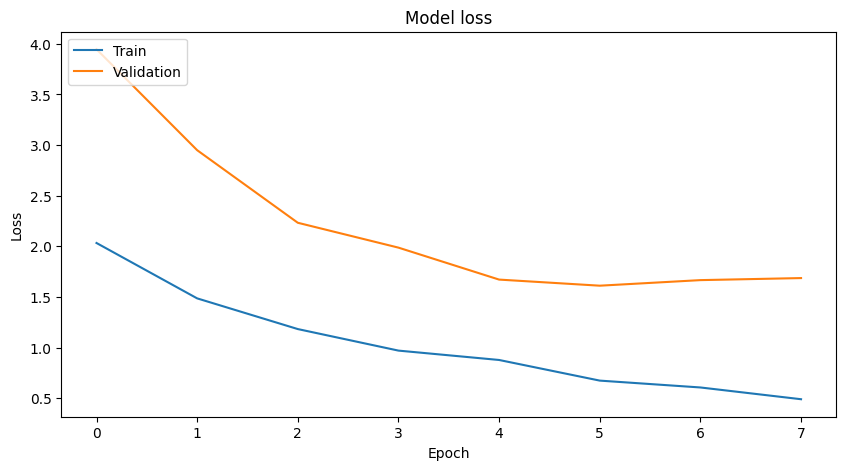

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model on the test set (you must load test data similar to train/val)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    seed=123
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Model Evaluation
loss, accuracy = model.evaluate(test_ds)
print(f"\n Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Save model
model.save("fruit_classifier_model.h5")
print("\nModel saved to fruit_classifier_model.h5")

# Load the model back
loaded_model = tf.keras.models.load_model("fruit_classifier_model.h5")
print("Model loaded from disk.")

# Re-evaluate loaded model
loss, accuracy = loaded_model.evaluate(test_ds)
print(f"\nLoaded Model Test Loss: {loss:.4f}")
print(f"Loaded Model Test Accuracy: {accuracy:.4f}")

Found 30 files belonging to 6 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2819 - loss: 1.7736



 Test Loss: 1.7746
Test Accuracy: 0.2667

Model saved to fruit_classifier_model.h5


Model loaded from disk.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.2819 - loss: 1.7736

Loaded Model Test Loss: 1.7746
Loaded Model Test Accuracy: 0.2667


In [ ]:
y_pred_probs = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = []
for _, labels in test_ds.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

# Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step

 Classification Report:
              precision    recall  f1-score   support

        acai       0.33      0.20      0.25         5
     cupuacu       0.30      0.60      0.40         5
    graviola       0.00      0.00      0.00         5
     guarana       0.29      0.40      0.33         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.22      0.40      0.29         5

    accuracy                           0.27        30
   macro avg       0.19      0.27      0.21        30
weighted avg       0.19      0.27      0.21        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Task2


In [ ]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(num_classes, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-class classification)

In [ ]:
from tensorflow.keras.models import Model
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Setup directory to save best model
checkpoint_path = "best_model.h5"
callbacks = [
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath=checkpoint_path,
    #     monitor='val_loss',
    #     save_best_only=True,
    #     verbose=1
    # ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

model.summary()

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.1215 - loss: 1.8435 - val_accuracy: 0.6111 - val_loss: 1.3435
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5298 - loss: 1.3818 - val_accuracy: 0.7778 - val_loss: 1.1261
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7784 - loss: 1.0746 - val_accuracy: 0.5556 - val_loss: 1.3495
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7572 - loss: 0.9045 - val_accuracy: 0.7778 - val_loss: 0.8046
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8628 - loss: 0.8046 - val_accuracy: 0.7778 - val_loss: 0.7949
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8215 - loss: 0.6691 - val_accuracy: 0.7778 - val_loss: 0.8145
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9002 - loss: 0.5742 - val_accuracy: 0.6667 - val_loss: 0.9584
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9398 - loss: 0.4968 - val_accuracy: 0.8333 - val_loss: 0

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,309,076 (62.21 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,062,926 (4.05 MB)

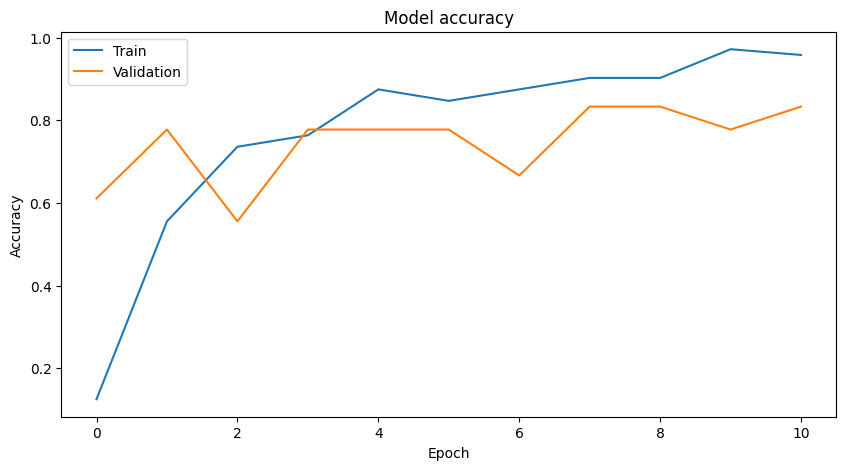

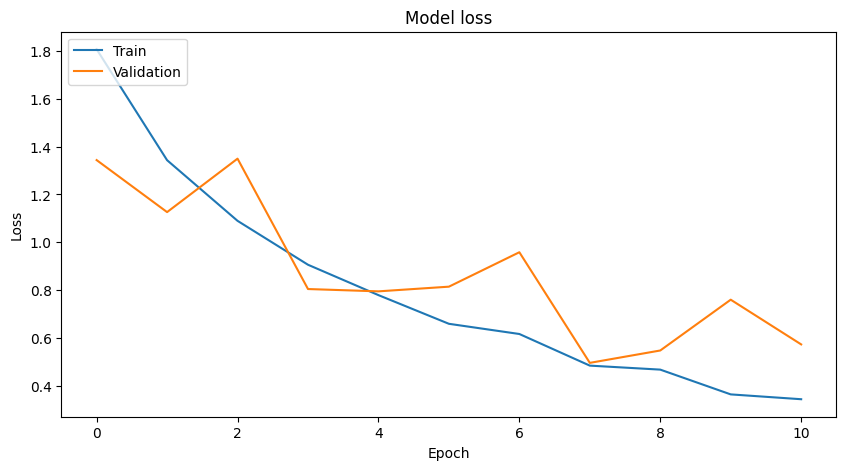

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()